## Refine TNK cell annotations for large intestine - relabelling uncertain cells based on majority voting

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import os
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import ast

In [2]:
sc.logging.print_header()

scanpy==1.8.0 anndata==0.8.0 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.3.5 scikit-learn==0.24.1 statsmodels==0.13.5 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.2


In [3]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [4]:
sc.set_figure_params(
    dpi=200,dpi_save=300,
    fontsize=12,
    frameon=False,
    transparent=True,
)

In [5]:
sns.set_style(style="white")
sns.set_context(context="paper")

In [6]:
adata = sc.read_h5ad('/nfs/team205/ao15/Megagut/Annotations_v3/h5ad/disease/compartments/Tcells_pooled_disease.gene_cellbender.good_qc_cluster_mito80.stringent_doublet_removed.hvg7500_noCC.scvi_output.lv20_batch256.with_raw_counts.scArches_broad_pred.20230124.h5ad')

In [7]:
adata

AnnData object with n_obs × n_vars = 89537 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spl

In [8]:
adata_scanvi = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/X_scANVI/disease/disease_fine_annot_predict_TNK_20230226.csv.gz',compression='gzip',index_col=0)

In [9]:
adata_scanvi

LV1       LV2       LV3       LV4  \
index                                                                      
AAACCTGAGGCCCTCA-4918STDY7273964 -0.893711 -0.052677 -0.201637  0.131956   
AAACCTGTCCAAACTG-4918STDY7273964 -0.094313  0.159906 -0.150523  0.015633   
AAACGGGGTTAAGAAC-4918STDY7273964 -0.452091 -0.588464  0.477104 -0.083655   
AAACGGGGTTGAGGTG-4918STDY7273964  0.031480  0.269420 -0.570353  0.040978   
AAACGGGTCATAGCAC-4918STDY7273964  0.026928  0.436080 -0.197455 -0.004883   
...                                    ...       ...       ...       ...   
TTCCCAGAGCGTGAGT-GSM4546346      -0.238365  0.570556  0.312066 -0.083714   
TTGCGTCGTACAGCAG-GSM4546346      -0.056510 -0.350858 -0.018827 -0.006641   
TTTACTGTCGTGGTCG-GSM4546346      -0.024961 -1.447564 -0.032682 -0.108191   
TTTGCGCGTGCACGAA-GSM4546346      -0.594652  0.879297 -0.042165 -0.006982   
TTTGGTTAGAAGCCCA-GSM4546346      -0.691161  0.075495 -0.037562 -0.044621   

                                       LV5       LV6       LV7       LV8  \
index                                                                      
AAACCTGAGGCCCTCA-4918STDY7273964  1.007388 -0.965268 -0.746116 -0.030217   
AAACCTGTCCAAACTG-4918STDY7273964 -0.075626  0.054341 -0.349800 -0.190158   
AAACGGGGTTAAGAAC-4918STDY7273964  0.501185 -0.040654  0.628492  0.586342   
AAACGGGGTTGAGGTG-4918STDY7273964  0.490107  0.283764  0.162645  0.446006   
AAACGGGTCATAGCAC-4918STDY7273964  0.069380  0.045874 -0.191007 -0.509009   
...                                    ...       ...       ...       ...   
TTCCCAGAGCGTGAGT-GSM4546346       0.090626  0.190163  0.739915  0.402066   
TTGCGTCGTACAGCAG-GSM4546346       1.106703 -0.491930  0.128192  0.438156   
TTTACTGTCGTGGTCG-GSM4546346      -0.758216  0.155032  0.138148 -1.047324   
TTTGCGCGTGCACGAA-GSM4546346       0.659025  0.543007 -0.106935  0.280390   
TTTGGTTAGAAGCCCA-GSM4546346       1.103462  0.447560  0.589557  0.865535   

                                       LV9      LV10      LV11      LV12  \
index                                                                      
AAACCTGAGGCCCTCA-4918STDY7273964 -0.670514  0.863974  0.022658 -0.034989   
AAACCTGTCCAAACTG-4918STDY7273964  0.011415  1.276259 -0.104790  0.002419   
AAACGGGGTTAAGAAC-4918STDY7273964 -0.012193 -0.363493  0.407546 -0.019430   
AAACGGGGTTGAGGTG-4918STDY7273964 -0.003175  2.038608  0.178489  0.002165   
AAACGGGTCATAGCAC-4918STDY7273964  0.101888  1.412580  0.071360  0.016480   
...                                    ...       ...       ...       ...   
TTCCCAGAGCGTGAGT-GSM4546346       0.018161 -2.144010 -0.179514 -0.001354   
TTGCGTCGTACAGCAG-GSM4546346       0.657247 -1.858527 -0.316423 -0.005987   
TTTACTGTCGTGGTCG-GSM4546346      -0.439705  0.532933 -0.356948 -0.067727   
TTTGCGCGTGCACGAA-GSM4546346       0.270152 -2.118536  0.236856 -0.027283   
TTTGGTTAGAAGCCCA-GSM4546346      -0.009267 -1.285665 -0.341140 -0.021551   

                                      LV13      LV14      LV15      LV16  \
index                                                                      
AAACCTGAGGCCCTCA-4918STDY7273964  0.020111 -0.029925  1.111086 -0.056799   
AAACCTGTCCAAACTG-4918STDY7273964  0.036030  0.022950 -1.331646 -0.084733   
AAACGGGGTTAAGAAC-4918STDY7273964  0.009008 -0.041604 -1.133909 -0.040155   
AAACGGGGTTGAGGTG-4918STDY7273964  0.055758 -0.024655 -0.879680 -0.073192   
AAACGGGTCATAGCAC-4918STDY7273964  0.030473  0.019318 -1.560949 -0.092981   
...                                    ...       ...       ...       ...   
TTCCCAGAGCGTGAGT-GSM4546346       0.039936  0.011807 -0.538121 -0.030217   
TTGCGTCGTACAGCAG-GSM4546346       0.046164 -0.017975 -0.622345  0.043693   
TTTACTGTCGTGGTCG-GSM4546346      -0.003228  0.016562 -0.698528 -0.024714   
TTTGCGCGTGCACGAA-GSM4546346       0.009730  0.020809 -0.415299 -0.042931   
TTTGGTTAGAAGCCCA-GSM4546346       0.014534 -0.037304  0.754632 -0.035077   

                                      LV17      LV18      LV19      LV20  
index   

In [10]:
adata.obsm['X_scANVI'] = adata_scanvi

In [11]:
adata_meta = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/disease/20230308/scanvi/disease_fine_annot_predict_TNK_20230226.csv',index_col=0)

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (82,83,84,86,100) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
adata_meta

latent_cell_probability  \
index                                                       
AAACCTGAGGCCCTCA-4918STDY7273964                 0.999551   
AAACCTGTCCAAACTG-4918STDY7273964                 0.999662   
AAACGGGGTTAAGAAC-4918STDY7273964                 0.999334   
AAACGGGGTTGAGGTG-4918STDY7273964                 0.999739   
AAACGGGTCATAGCAC-4918STDY7273964                 0.999727   
...                                                   ...   
TTCCCAGAGCGTGAGT-GSM4546346                      0.999724   
TTGCGTCGTACAGCAG-GSM4546346                      0.999578   
TTTACTGTCGTGGTCG-GSM4546346                      0.999522   
TTTGCGCGTGCACGAA-GSM4546346                      0.999673   
TTTGGTTAGAAGCCCA-GSM4546346                      0.999554   

                                  latent_RT_efficiency cecilia22_predH  \
index                                                                    
AAACCTGAGGCCCTCA-4918STDY7273964              1.287072         T cells   
AAACCTGTCCAAACTG-4918STDY7273964              1.191093         T cells   
AAACGGGGTTAAGAAC-4918STDY7273964              0.952725         T cells   
AAACGGGGTTGAGGTG-4918STDY7273964              1.484298         T cells   
AAACGGGTCATAGCAC-4918STDY7273964              1.730684         T cells   
...                                                ...             ...   
TTCCCAGAGCGTGAGT-GSM4546346                   1.267164         T cells   
TTGCGTCGTACAGCAG-GSM4546346                   0.989256         T cells   
TTTACTGTCGTGGTCG-GSM4546346                   1.008884         T cells   
TTTGCGCGTGCACGAA-GSM4546346                   1.509161         T cells   
TTTGGTTAGAAGCCCA-GSM4546346                   1.211305         T cells   

                                  cecilia22_predH_prob  \
index                                                    
AAACCTGAGGCCCTCA-4918STDY7273964              0.999993   
AAACCTGTCCAAACTG-4918STDY7273964              0.999954   
AAACGGGGTTAAGAAC-4918STDY7273964              0.999064   
AAACGGGGTTGAGGTG-4918STDY7273964              0.999997   
AAACGGGTCATAGCAC-4918STDY7273964              0.999999   
...                                                ...   
TTCCCAGAGCGTGAGT-GSM4546346                   0.999987   
TTGCGTCGTACAGCAG-GSM4546346                   0.997926   
TTTACTGTCGTGGTCG-GSM4546346                   0.999693   
TTTGCGCGTGCACGAA-GSM4546346                   1.000000   
TTTGGTTAGAAGCCCA-GSM4546346                   1.000000   

                                 cecilia22_predH_uncertain  \
index                                                        
AAACCTGAGGCCCTCA-4918STDY7273964                   T cells   
AAACCTGTCCAAACTG-4918STDY7273964                   T cells   
AAACGGGGTTAAGAAC-4918STDY7273964                   T cells   
AAACGGGGTTGAGGTG-4918STDY7273964                   T cells   
AAACGGGTCATAGCAC-4918STDY7273964                   T cells   
...                                                    ...   
TTCCCAGAGCGTGAGT-GSM4546346                        T cells   
TTGCGTCGTACAGCAG-GSM4546346                        T cells   
TTTACTGTCGTGGTCG-GSM4546346                        T cells   
TTTGCGCGTGCACGAA-GSM4546346                        T cells   
TTTGGTTAGAAGCCCA-GSM4546346                        T cells   

                                              cecilia22_predL  \
index                                                           
AAACCTGAGGCCCTCA-4918STDY7273964     Tcm/Naive helper T cells   
AAACCTGTCCAAACTG-4918STDY7273964     Tcm/Naive helper T cells   
AAACGGGGTTAAGAAC-4918STDY7273964     Tcm/Naive helper T cells   
AAACGGGGTTGAGGTG-4918STDY7273964  Tcm/Naive cytotoxic T cells   
AAACGGGTCATAGCAC-4918STDY7273964     Tcm/Naive helper T cells   
...                                                       ...   
TTCCCAGAGCGTGAGT-GSM4546346                Regulatory T cells   
TTGCGTCGTACAGCAG-GSM4546346                Regulatory T cells   
TTTACTGTCGTGGTCG-GSM4546346                Regulatory T cells   


In [13]:
adata.obs = adata_meta

In [14]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


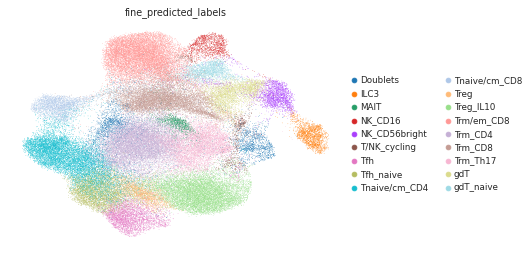

In [15]:
sc.pl.umap(adata, color=['fine_predicted_labels'])

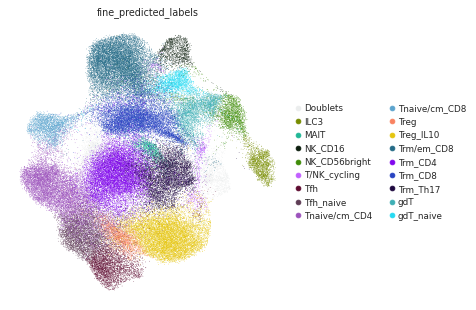

In [16]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels',palette = ['#ebeded',#doublets
                                                          '#778c00', #ILC3
'#21b796', #MAIT
'#0c1e0e',#NK_CD16
'#3f8c08', #NK CD56
'#c260ff',#T/NK cyling 
'#5e0b30',#Tfh
'#5e3c55',#tfh naive                             
'#9c53bc',#Tnaive/cm CD4
'#5ca4ce',#t naive/CM Cd8
'#f98261',#treg
'#e5c510',#treg il10
'#256b87',#Tem CD8
'#8107ed',#trm cd4                                
'#2844c1',#trm cd8
'#1e093f',#trm th17
'#3fafb5',#gdt                               
#'#5ac4e8',#Tem/emra cd8
'#26daf2'#gdt naive
                                                         ],size=1.5,save='TNK_scanviannot_predicted.pdf')

In [17]:
adata.X.max()

7139.0

In [18]:
adata.layers['counts'] = adata.X

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [20]:
marker_genes_dict = {'General T cell markers': ['CD3D','CD3E','CD3G','CD8A','CD8B','CD4'],
                     'ILC3': ['RORC','PCDH9','KIT','LST1','IL7R'],
                     'MAIT': ['SLC4A10','TRAV1-2'],
                     'NK_CD16': ['FCGR3A','GNLY','GZMB','NKG7'],
                     'NK_CD56bright': ['XCL1','IL2RB','NCAM1','NCR1','FCER1G'],
                     'T follicular helper markers':['CXCR5','BCL6','PDCD1','CD40LG'],
                     'Naive T cell markers': ['CCR7','SELL'],
                     'Tregs': ['FOXP3','CTLA4','IL2RA','IL10'],
                    'Trm/em_CD8':['GZMK','CRTAM','EOMES'],
                    'Tissue resident memory T markers':['ITGAE','ITGA1','SPRY1'],
                    'Trm_Th17':['IL17A','CCR6','CCL20'],
                    'gdT markers':['KLRC2','TRDC','TRGC1','KIR2DL4']}

In [21]:
adata

AnnData object with n_obs × n_vars = 89537 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spl

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


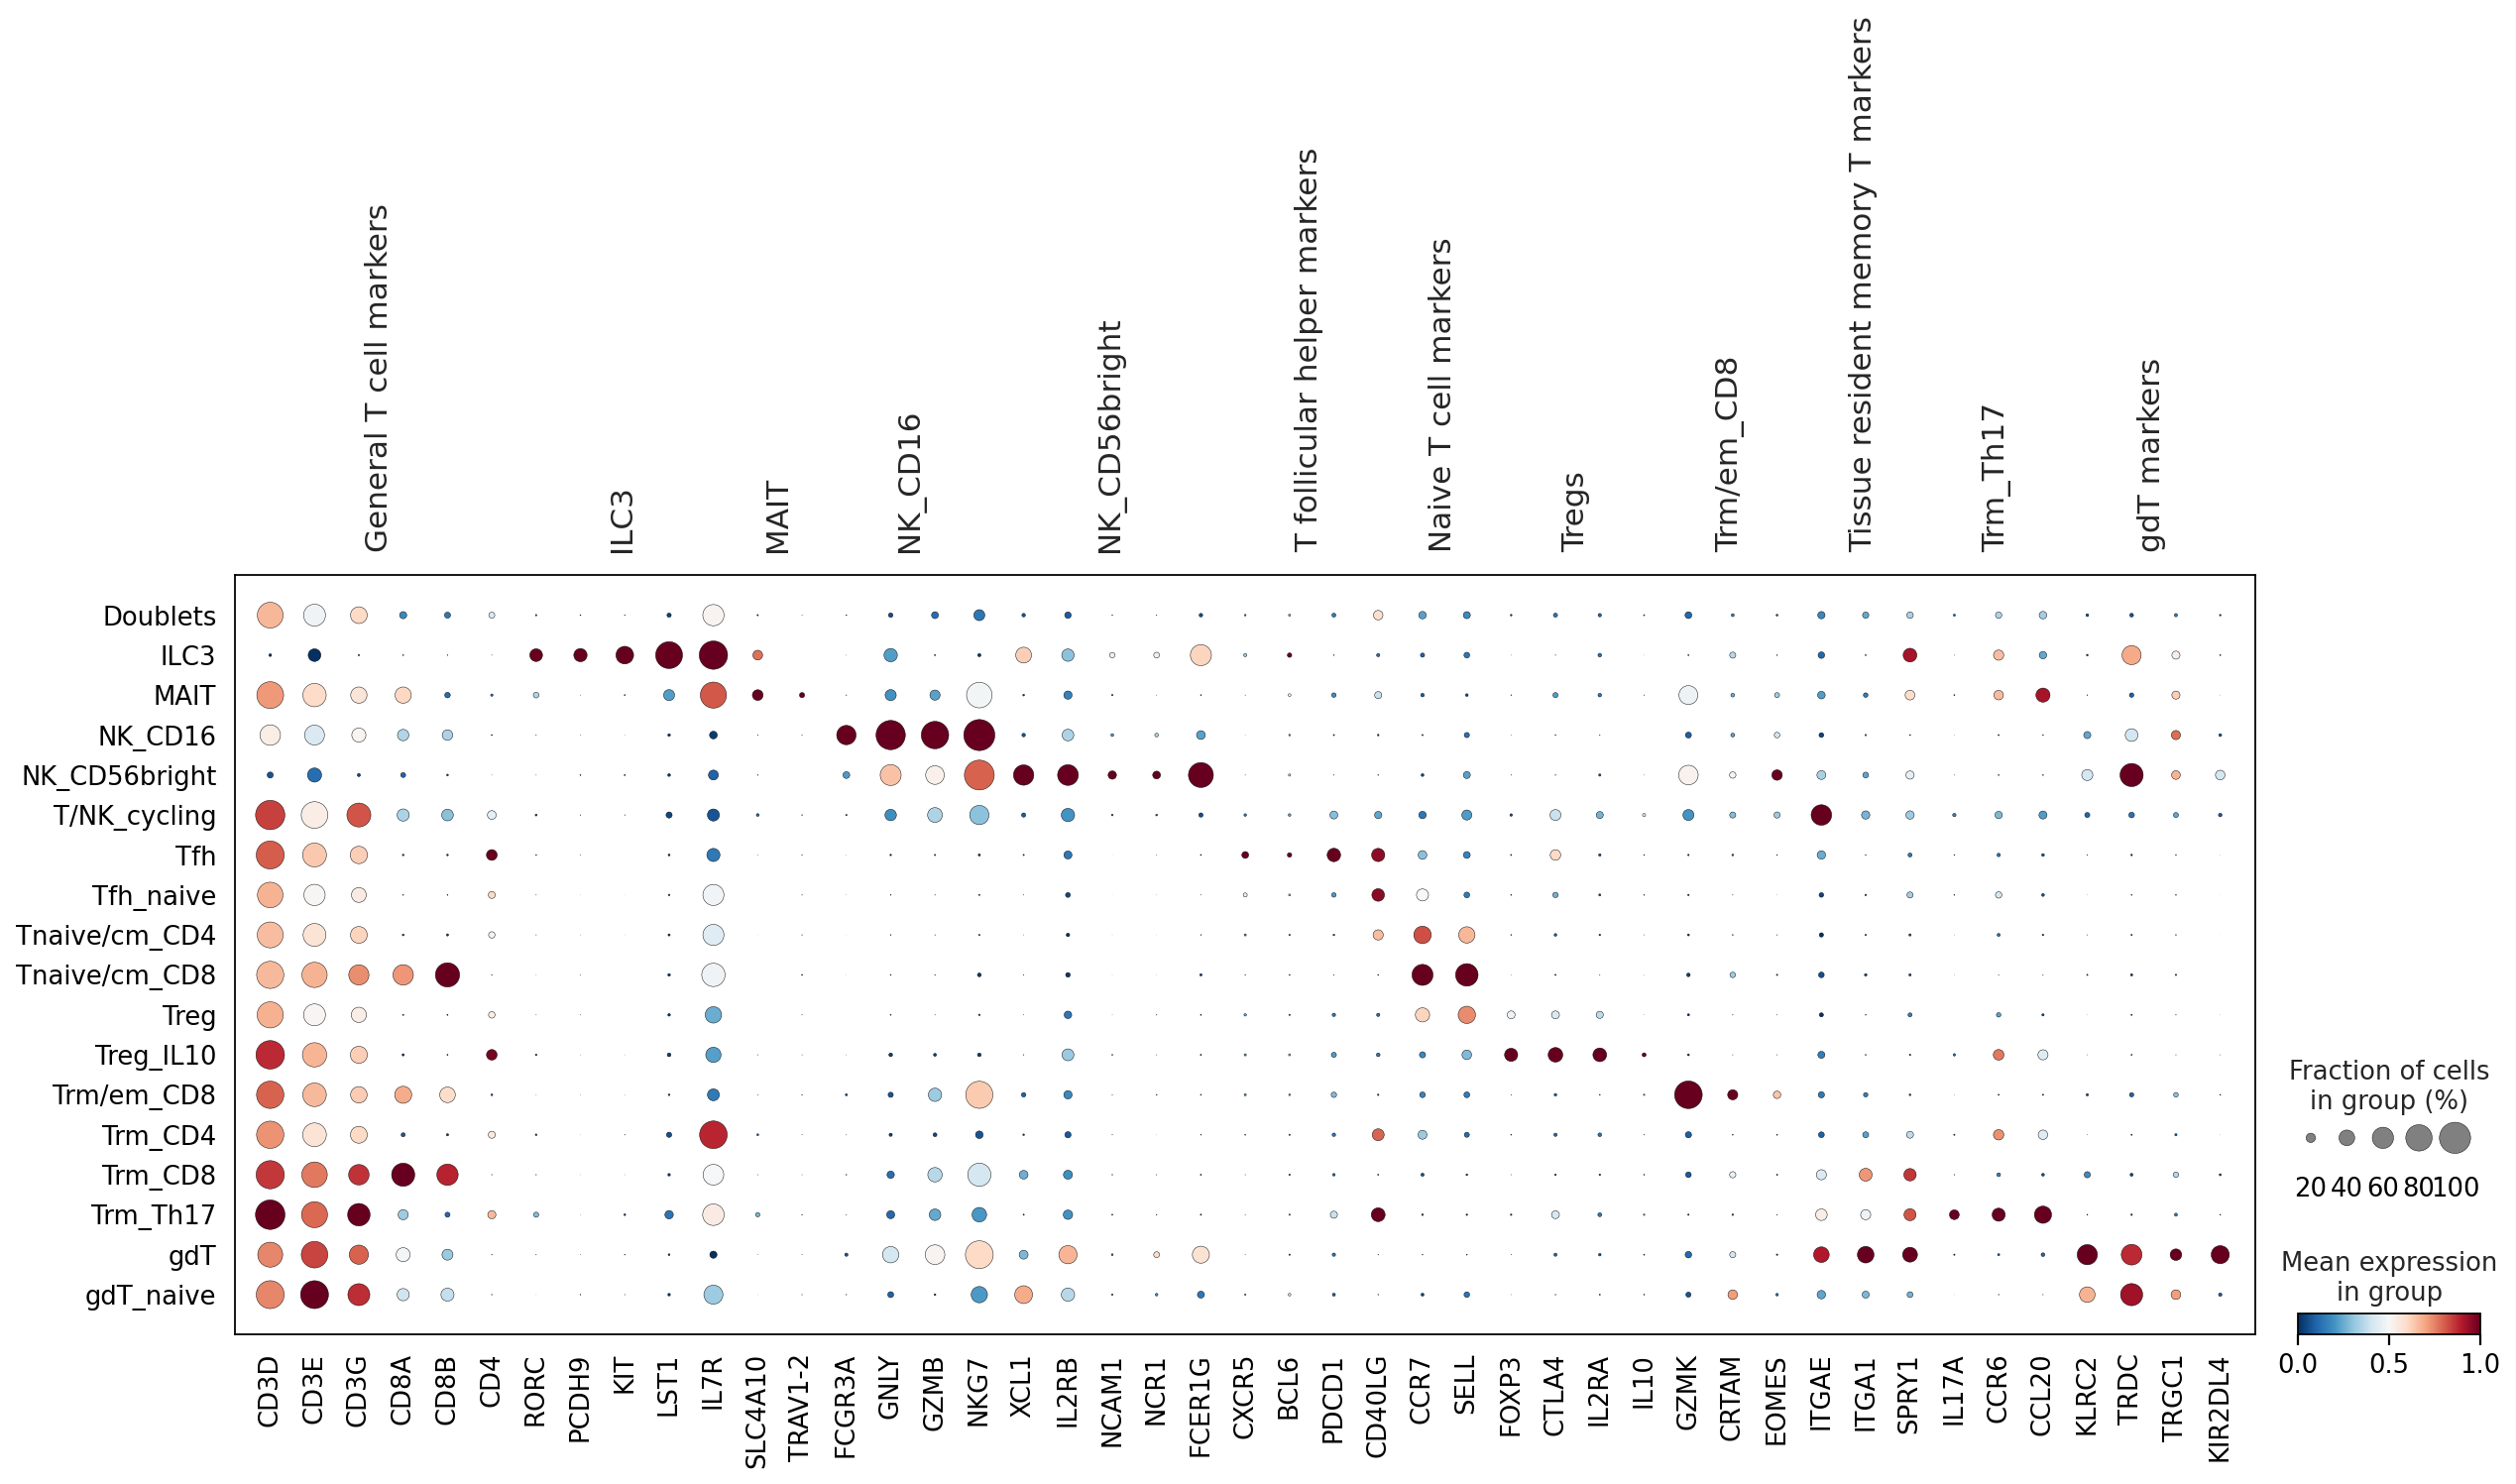

In [22]:
sc.set_figure_params(dpi_save = 300)
sc.pl.dotplot(adata,var_names=marker_genes_dict,groupby='fine_predicted_labels',color_map='RdBu_r', standard_scale='var')

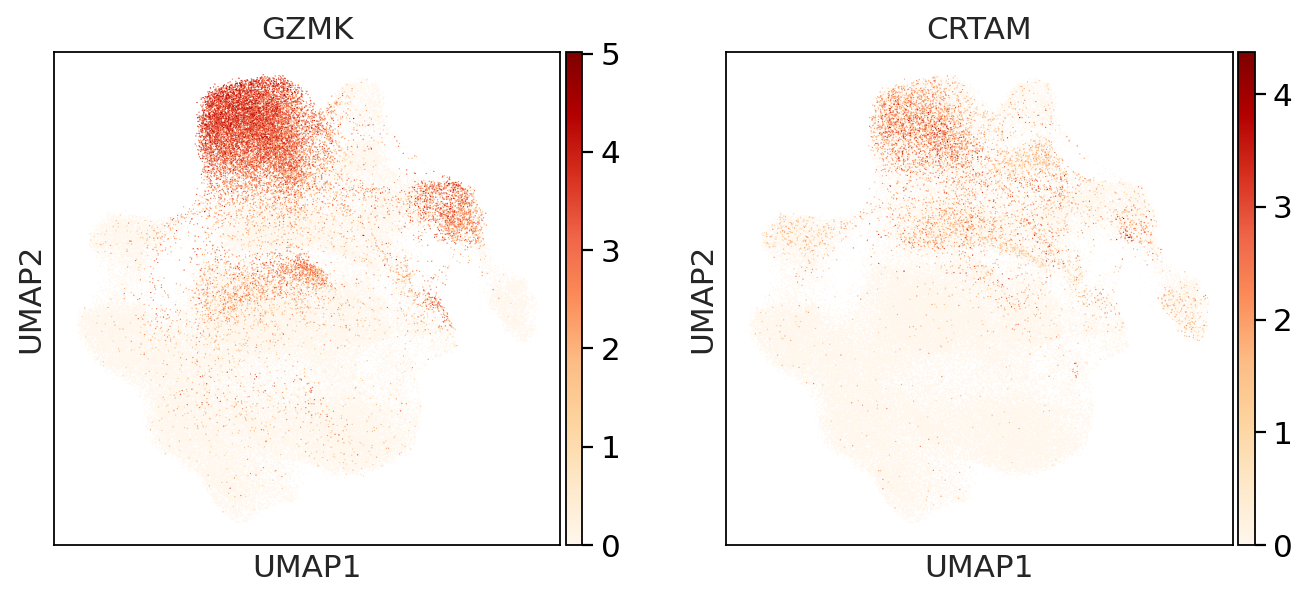

In [23]:
sc.pl.umap(adata,color=['GZMK','CRTAM'],cmap='OrRd')

In [24]:
uncert = adata.obs[['fine_predicted_labels','fine_predicted_labels_uncertainty']] 

In [25]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(adata.obs['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.5200046300888062


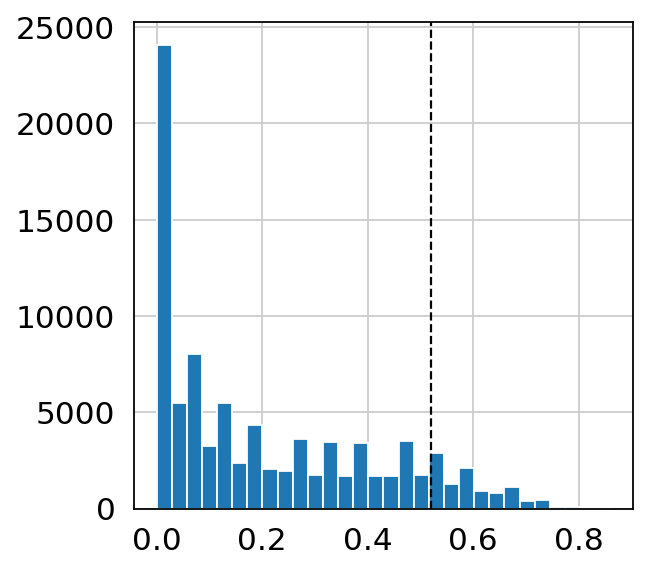

In [26]:
#plot uncertainty distribution
plt.hist(adata.obs['fine_predicted_labels_uncertainty'], bins=30)
plt.axvline(x=p, color='black', linestyle='dashed', linewidth=1)
plt.savefig('TNK_scanviannot_uncertdist.pdf', format='pdf')
plt.show()

In [27]:
uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')

<ipython-input-27-905f2ed234d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')


In [28]:
adata.obs['fine_predicted_labels'].unique()

['gdT_naive', 'Tnaive/cm_CD4', 'Tfh_naive', 'Tfh', 'Treg_IL10', ..., 'NK_CD56bright', 'T/NK_cycling', 'ILC3', 'gdT', 'MAIT']
Length: 18
Categories (18, object): ['Doublets', 'ILC3', 'MAIT', 'NK_CD16', ..., 'Trm_CD8', 'Trm_Th17', 'gdT', 'gdT_naive']

In [29]:
#mark cells are unknown based on cut off of 90th percentile rounded to the nearest second decimal
uncert.loc[uncert["fine_predicted_labels_uncertainty"] > 0.52, "fine_predicted_labels"] = "Unknown"

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [30]:
adata.obs['fine_predicted_labels_uncertflagged'] = adata.obs['fine_predicted_labels']

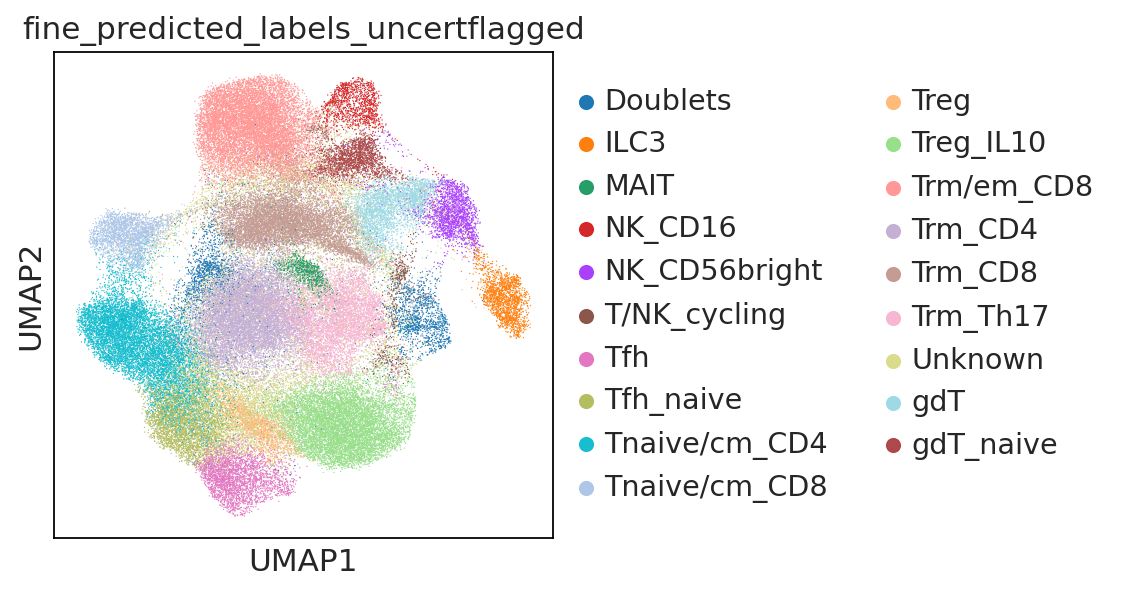

In [31]:
ON = {O:N for O,N in zip(uncert.index,uncert["fine_predicted_labels"])}
adata.obs["fine_predicted_labels_uncertflagged"] = [ON[O] if O in ON else N for O,N in zip(adata.obs_names, adata.obs["fine_predicted_labels_uncertflagged"])]
sc.pl.umap(adata,color='fine_predicted_labels_uncertflagged')

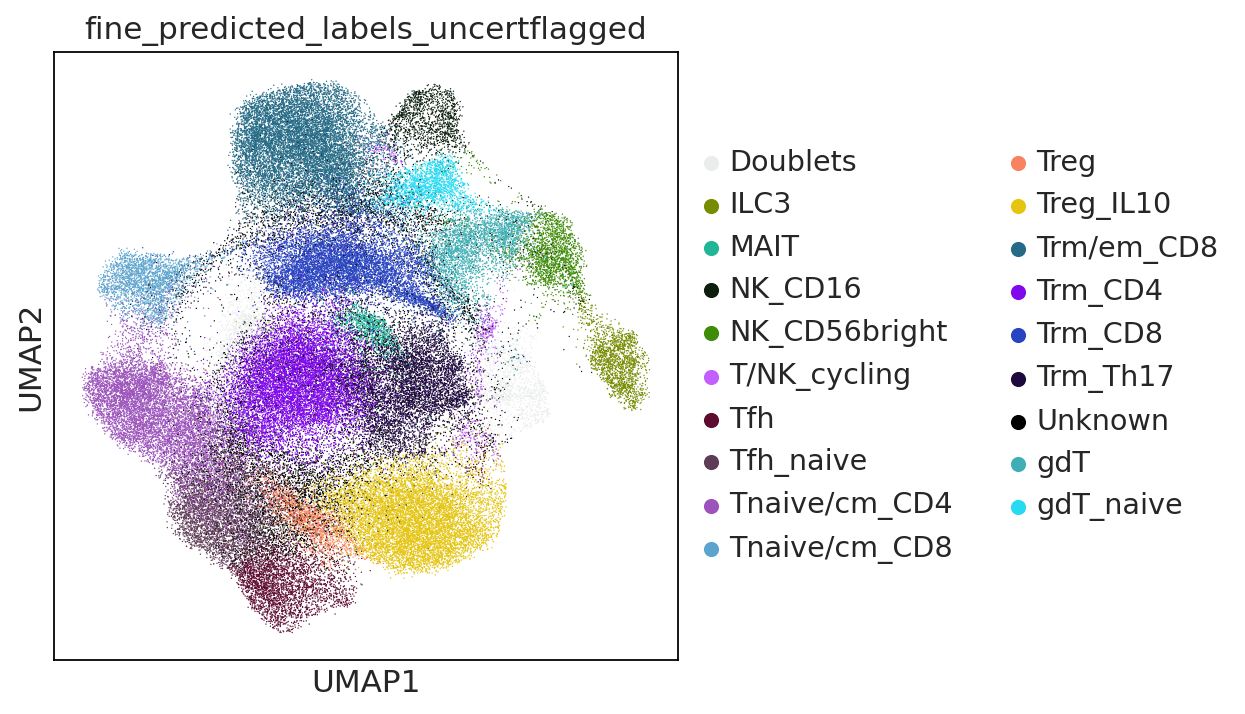

In [32]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels_uncertflagged',palette = ['#ebeded',#doublets
                                                          '#778c00', #ILC3
'#21b796', #MAIT
'#0c1e0e',#NK_CD16
'#3f8c08', #NK CD56
'#c260ff',#T/NK cyling 
'#5e0b30',#Tfh
'#5e3c55',#tfh naive                             
'#9c53bc',#Tnaive/cm CD4
'#5ca4ce',#t naive/CM Cd8
'#f98261',#treg
'#e5c510',#treg il10
'#256b87',#Tem CD8
'#8107ed',#trm cd4                                
'#2844c1',#trm cd8
'#1e093f',#trm th17
                                                                        '#000000',#unknown
'#3fafb5',#gdt                               
#'#5ac4e8',#Tem/emra cd8
                                                                           
'#26daf2',#gdt naive
                                                       
                                               
                                               
    
    
                                              ],size=1.5,save='TNK_scanviannot_uncert.pdf')

In [33]:
annot = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/disease_annot/resolved_annot/TNK_disease_annot.csv',index_col=0)

In [34]:
adata.obs['fine_predicted_labels_resolved'] = annot.fine_predicted_labels_resolved

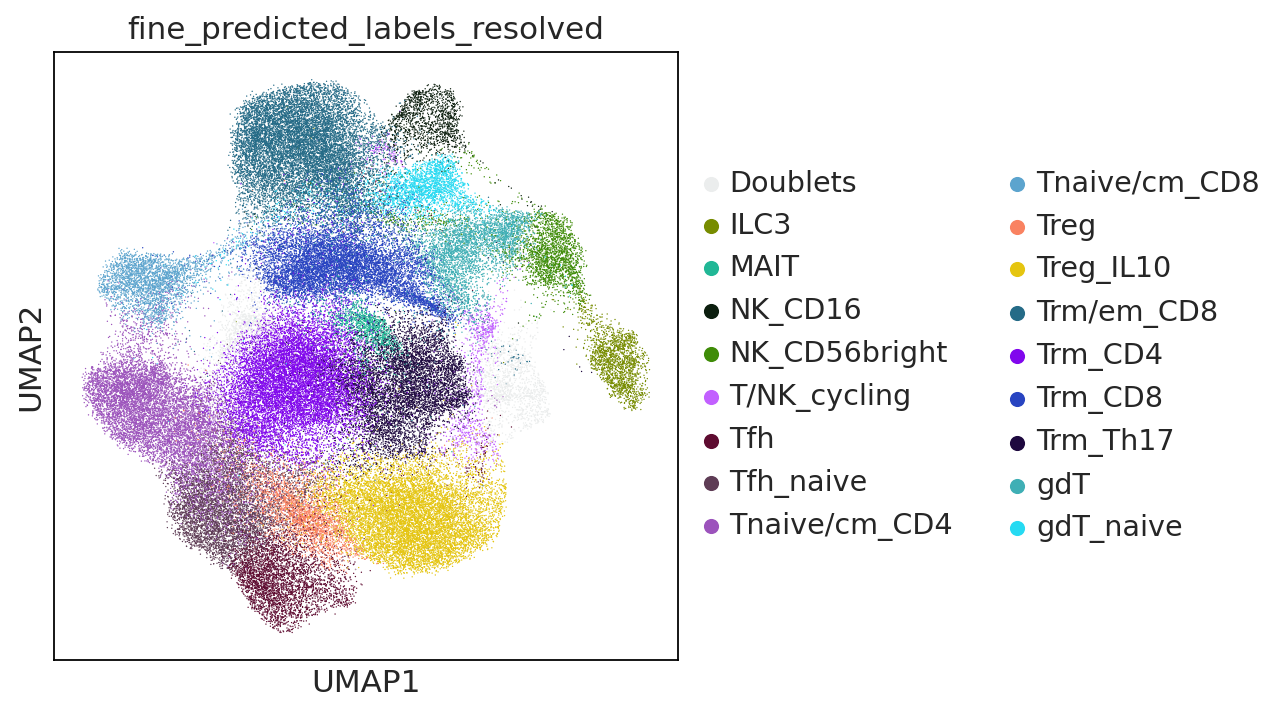

In [35]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels_resolved',palette = ['#ebeded',#doublets
                                                          '#778c00', #ILC3
'#21b796', #MAIT
'#0c1e0e',#NK_CD16
'#3f8c08', #NK CD56
'#c260ff',#T/NK cyling 
'#5e0b30',#Tfh
'#5e3c55',#tfh naive                             
'#9c53bc',#Tnaive/cm CD4
'#5ca4ce',#t naive/CM Cd8
'#f98261',#treg
'#e5c510',#treg il10
'#256b87',#Tem CD8
'#8107ed',#trm cd4                                
'#2844c1',#trm cd8
'#1e093f',#trm th17
                                                                        #'#000000',#unknown
'#3fafb5',#gdt                               
#'#5ac4e8',#Tem/emra cd8
                                                                           
'#26daf2',#gdt naive
                                               
                                               
    
    
                                              ],size=1.5,save='TNK_scanviannot_resolved.pdf')

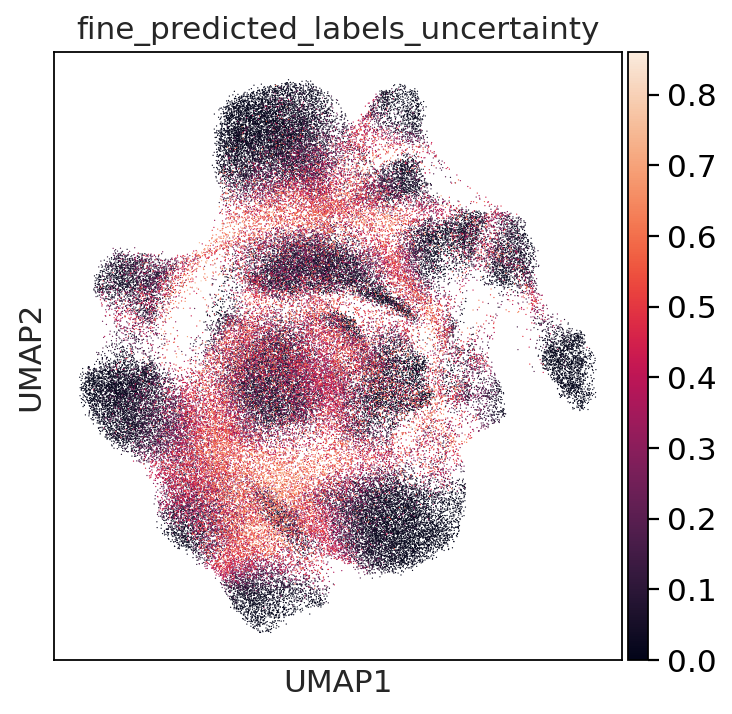

In [36]:
sc.pl.umap(adata,color='fine_predicted_labels_uncertainty',save='TNK_scanviannot_uncertainty.pdf')

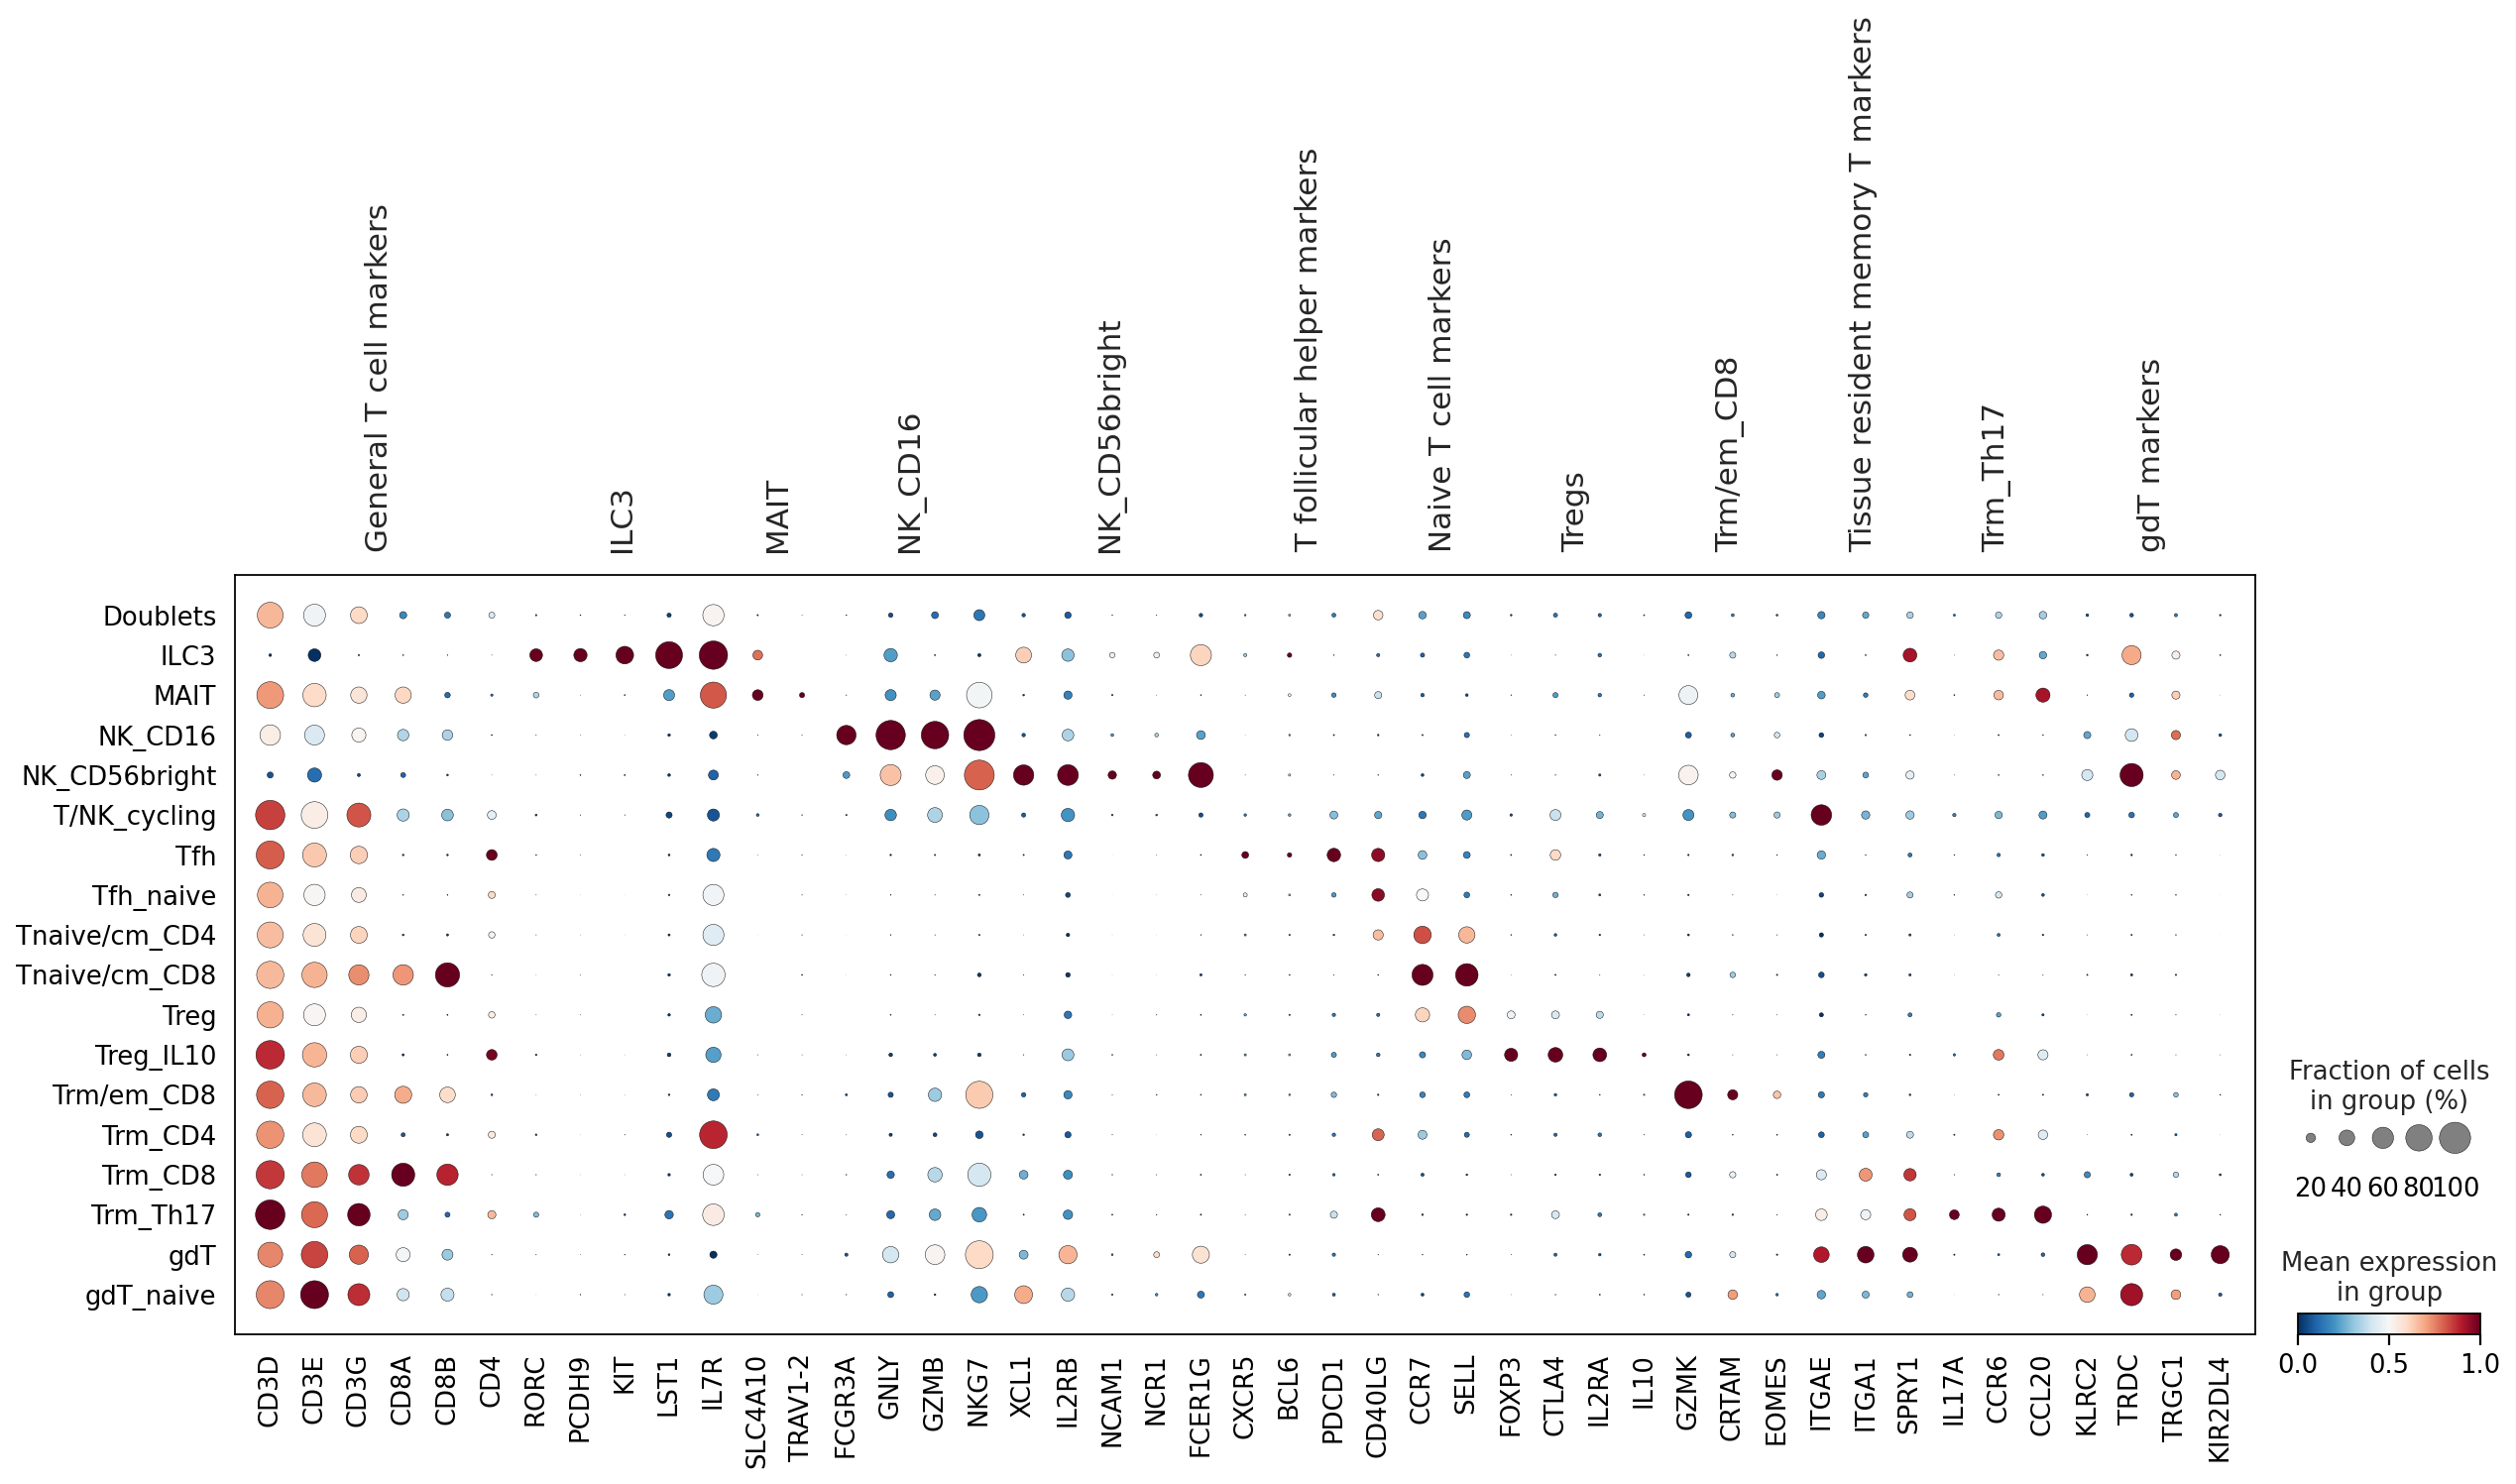

In [37]:
sc.set_figure_params(dpi_save = 300)
sc.pl.dotplot(adata,var_names=marker_genes_dict,groupby='fine_predicted_labels',color_map='RdBu_r', standard_scale='var',save='TNK_scanviannot_resolvedmarkers.pdf')

In [38]:
colors={
    'Doublets':'#ebeded',
    'EC_venous': '#2a4858',
  'Mast': '#826e91',
  'EC_capillary': '#855f9a',
  'DC_cDC1': '#8c543f',
  'Monocyte': '#5baf07',
  'DC_cDC2': '#cfdb65',
  'Basal': '#727271',
  'Treg_IL10': '#e5c510',
  'Crypt_fibroblast_PI16': '#bd7879',
  'Macrophage': '#486626',
  'Vascular_smooth_muscle': '#1E4147',
  'Lamina_propria_fibroblast_ADAMDEC1': '#e95e50',
  'Epithelial_cycling_G2M': '#ff3c4b',
  'Keratinocyte_stratified': '#EDD3E0',
  'Trm/em_CD8': '#256b87',
  'Pericyte': '#437356',
  'Oral_mucosa_fibroblast': '#303267',
  'Macrophage_MMP9': '#a5f002',
  'EC_lymphatic': '#999999',
  'Rectum_fibroblast': '#522e25',
  'Trm_Th17': '#1e093f',
  'DC_migratory': '#e6a519',
  'Epithelial_cycling_S': '#ff8433',
  'Trm_CD4': '#8107ed',
  'NK_CD16': '#0c1e0e',
  'Macrophage_LYVE1': '#8fd9d0',
  'Trm_CD8': '#2844c1',
  'Macrophage_TREM2': '#42c7ac',
  'Keratinocyte_inflammatory': '#E0AC9D',
  'Tnaive/cm_CD4': '#9c53bc',
  'DC_pDC': '#bdb197',
  'Villus_fibroblast_F3': '#d64582',
  'EC_arterial_2': '#ca6092',
  'EC_arterial_1': '#fa6e6e',
  'gdT': '#3fafb5',
  'B_memory': '#a33c22',
  'T/NK_cycling': '#c260ff',
  'Immune_recruiting_pericyte': '#AAC789',
  'MAIT': '#21b796',
  'ILC3': '#778c00',
  'Melanocyte': '#886F61',
  'Tfh_naive': '#5e3c55',
  'Keratinocyte_outer': '#BF7A9C',
  'EC_cycling': '#fac06e',
  'Tnaive/cm_CD8': '#5ca4ce',
  'NK_CD56bright': '#3f8c08',
  'B_naive': '#9b0319',
  'B_preB': '#8a4682',
  'Treg': '#f98261',
  'B_proB': '#d34794',
  'B_plasmablast': '#9e53db',
  'B_plasma_IgG': '#632f17',
  'Megakaryocyte/platelet': '#c730aa',
  'TA': '#b85f1c',
  'Mono/neutrophil_MPO': '#2a497a',
  'B_plasma_IgA1': '#f76c56',
  'Macrophage_CD5L': '#caf9cf',
  'Tfh': '#5e0b30',
  'Oesophagus_fibroblast': '#63A0C0',
  'B_plasma_IgA2': '#d6558d',
  'gdT_naive': '#26daf2',
  'B_GC_I': '#db9602',
  'B_plasma_IgM': '#c66d31',
  'DC_langerhans': '#c7a642',
  'Fibroblast_reticular': '#f0c134',
  'B_GC_II': '#e2d138',
  'Follicular_DC': '#f0982c',
  'Microfold': '#e55b85',
  'Enterocyte': '#e1b5e6',
  'Epithelial_stem': '#c924b9',
  'Surface_foveolar': '#d9b74a',
  'Mucous_gland_neck': '#f7b37c',
  'Cycling': '#ff8433',
  'Pareital': '#d45f80',
  'Enteroendocrine_MX': '#292663',
  'Myofibroblast': '#CCAE91',
  'Glial_2': '#0D6986',
  'Enteric_neural_crest_cycling': '#DBA507',
  'Enterochromaffin': '#22517a',
  'Chief': '#c95340',
  'Glial/Enteric_neural_crest': '#a8c545',
  'Enteroendocrine_G': '#2f3f4d',
  'Neuroblast': '#c50637',
  'Goblet_progenitor': '#e9f7ad',
  'Goblet': '#6c9939',
  'Enteroendocrine': '#68b7fc',
  'Erythrocytes': '#0e539c',
  'Enteroendocrine_X': '#7292ad',
  'Glial_3': '#053240',
  'Goblet_cycling': '#d1d14f',
  'BEST4_enterocyte_colonocyte': '#39997c',
  'Tuft': '#9d9dff',
  'Paneth': '#79508f',
  'Serous': '#C9DE55',
  'Mucous': '#67cc8e',
  'Duct': '#7D9100',
  'Seromucous': '#ACEBAE',
  'Myoepithelial': '#572300',
  'Ionocytes': '#9d9dff',
  'Colonocyte': '#d66245',
  'Mature_colonocyte': '#fa6161',
  'Mesoderm_2': '#b4793b',
  'Branch_A_inhibtory_motor_neuron': '#a39bcb',
  'SMC_PPLP2': '#d4d4e8',
  'Cycling_fibroblast': '#d65151',
  'ICC': '#69479b',
  'Branch_B_excitatory_motor_neuron': '#496695',
  'SMC_CAPN3': '#968dc6',
  'Mesoderm_1': '#663818',
  'Branch_B_primary_afferent_neuron': '#909134',
  'Proximal_progenitor_DUO/JEJ': '#fac219',
  'SMC_CAPN3_cycling': '#76738e',
  'Glial_1': '#8EC7D2',
  'Branch_A_primary_afferent_neuron': '#27bdbf',
  'Branch_A_interneuron': '#67608a',
  'NTS': '#baada4',
  'Proximal_progenitor_ILE': '#8f6e0d',
  'Enteroendocrine_progenitor': '#aeebdf',
  'Mesothelium': '#8F6592',
  'Distal_progenitor': '#dbc697',
  'Angiogenic_pericyte': '#308587',
  'Eosinophil/basophil': '#8b4eba',
  'CLDN10': '#706d65',
  'Distal_progenitor_PRAC1': '#8f8161',
  'Immature_pericyte': '#90c496',
  'Mesenchymal_LTO': '#f7eb59',
  'Gastric_fetal_epithelial': '#a01160',
  'DCS_MUC17_cycling': '#99216b',
  'DCS_MUC17': '#9c6b73',
  'Gland_basal': '#404040',
  'Gland_fetal': '#168039',
  'Basal_cycling': '#d1bf82',
  'Keratinocyte_fetal': '#d8306e',
  'Gland_duct': '#7D9100',
  'Gland_mucous': '#67cc8e',
  'Myoblast/myocyte': '#e2798d',
  'Unknown': '#000000'}

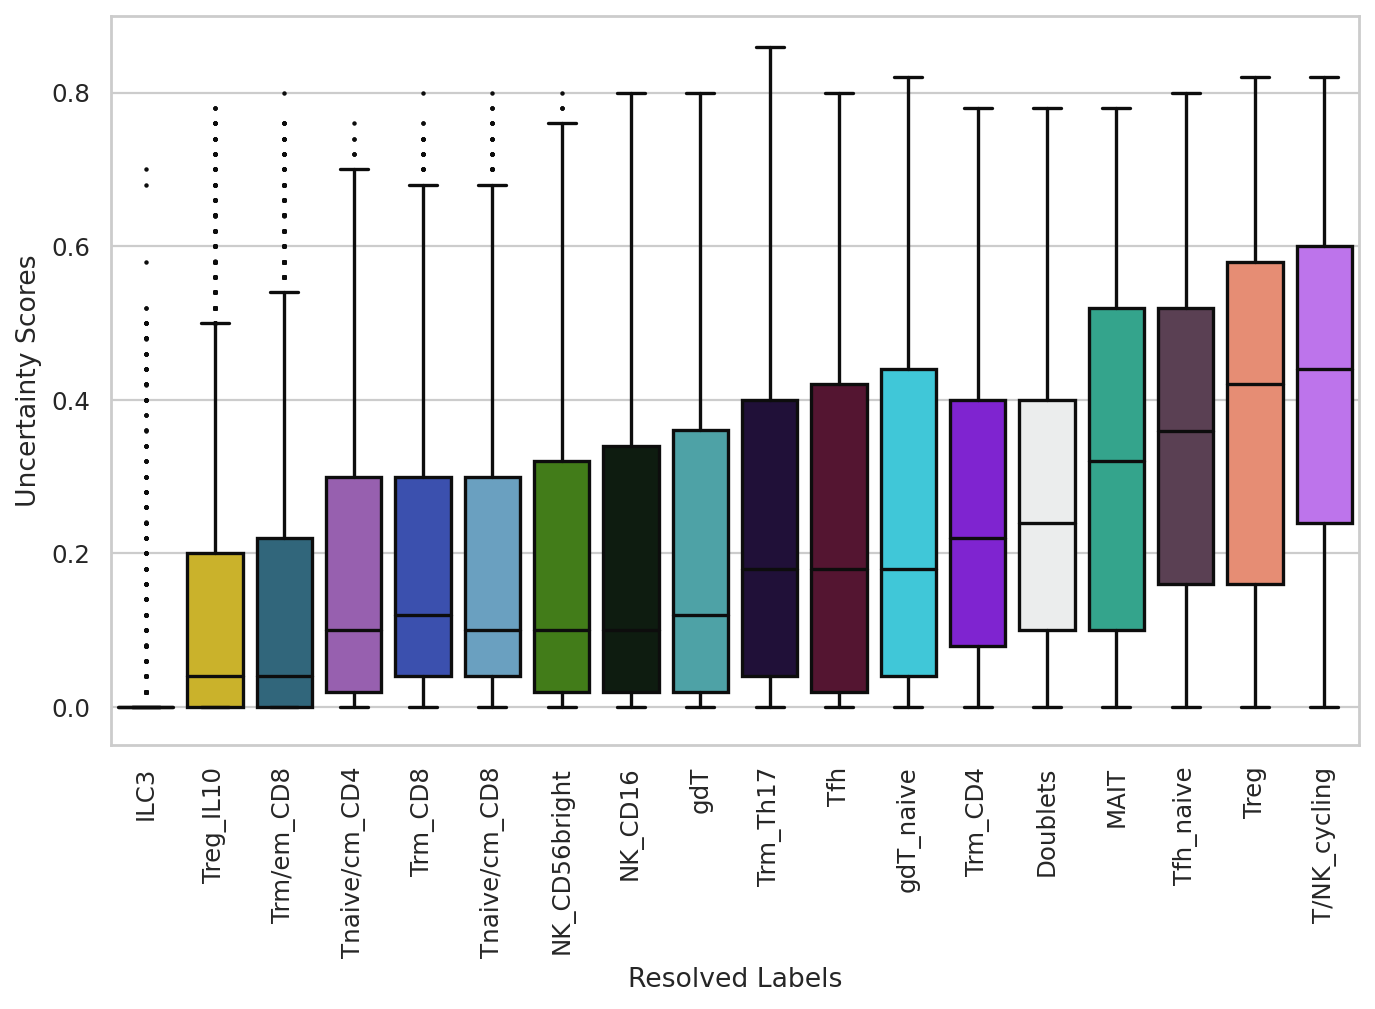

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but seaborn can enhance the style

# Assuming adata is your AnnData object

# Combine the two variables into a DataFrame for easier plotting
data_to_plot = adata.obs[['fine_predicted_labels_uncertainty', 'fine_predicted_labels_resolved']]

# Use seaborn for better styling (optional)
sns.set(style="whitegrid")

mean_uncertainty = data_to_plot.groupby('fine_predicted_labels_resolved')['fine_predicted_labels_uncertainty'].mean()

# Sort the categories based on mean uncertainty
sorted_categories = mean_uncertainty.sort_values().index

# Create a box and whisker plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
ax = sns.boxplot(x='fine_predicted_labels_resolved', y='fine_predicted_labels_uncertainty', 
            data=data_to_plot,palette=colors,order=sorted_categories,flierprops=dict(marker='o', markerfacecolor='gray', markersize=1))

# Add labels and title
plt.xticks(rotation=90)
plt.xlabel('Resolved Labels')
plt.ylabel('Uncertainty Scores')
ax.set_ylim(-0.05, 0.9)

# Save the plot as a PDF file
plt.savefig('TNK_boxplot_uncertainty_scores.pdf', format='pdf')

# Show the plot
plt.show()

In [40]:
#related to revisions point 2.10 "Have you done differential gene expression analysis of the unknonw cells versus the annotated cells in their cluster?"

In [41]:
adata

AnnData object with n_obs × n_vars = 89537 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spl

In [42]:
adata.obs['unknown_clusterlabel'] = adata.obs['fine_predicted_labels_uncertflagged'].astype(str) + '_' + adata.obs['fine_predicted_labels_resolved'].astype(str)

In [43]:
adata.obs['unknown_clusterlabel'].value_counts()

Trm/em_CD8_Trm/em_CD8          11022
Trm_CD4_Trm_CD4                10600
Treg_IL10_Treg_IL10             9241
Tnaive/cm_CD4_Tnaive/cm_CD4     9144
Trm_CD8_Trm_CD8                 8358
Trm_Th17_Trm_Th17               6046
Tfh_naive_Tfh_naive             3867
gdT_gdT                         3212
Tfh_Tfh                         3155
Doublets_Doublets               2869
Tnaive/cm_CD8_Tnaive/cm_CD8     2453
gdT_naive_gdT_naive             2068
NK_CD56bright_NK_CD56bright     2034
ILC3_ILC3                       1756
Treg_Treg                       1663
Unknown_Tfh_naive               1340
NK_CD16_NK_CD16                 1216
Unknown_Trm_CD4                 1174
Unknown_Treg                    1030
MAIT_MAIT                        998
Unknown_Trm_Th17                 768
Unknown_Trm/em_CD8               644
T/NK_cycling_T/NK_cycling        624
Unknown_Tfh                      574
Unknown_Trm_CD8                  467
Unknown_gdT                      466
Unknown_T/NK_cycling             434
U

In [44]:
adata.X.max()

8.704432

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/tools/_rank

         Falling back to preprocessing with `sc.pp.pca` and default params.


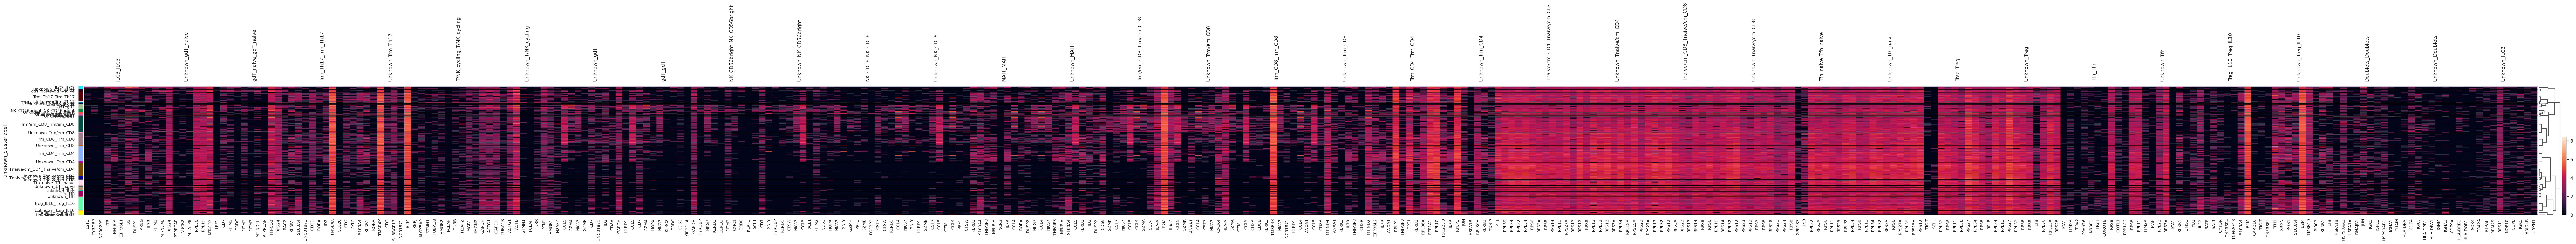

In [46]:
sc.tl.rank_genes_groups(adata, 'unknown_clusterlabel', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata, show_gene_labels=True)

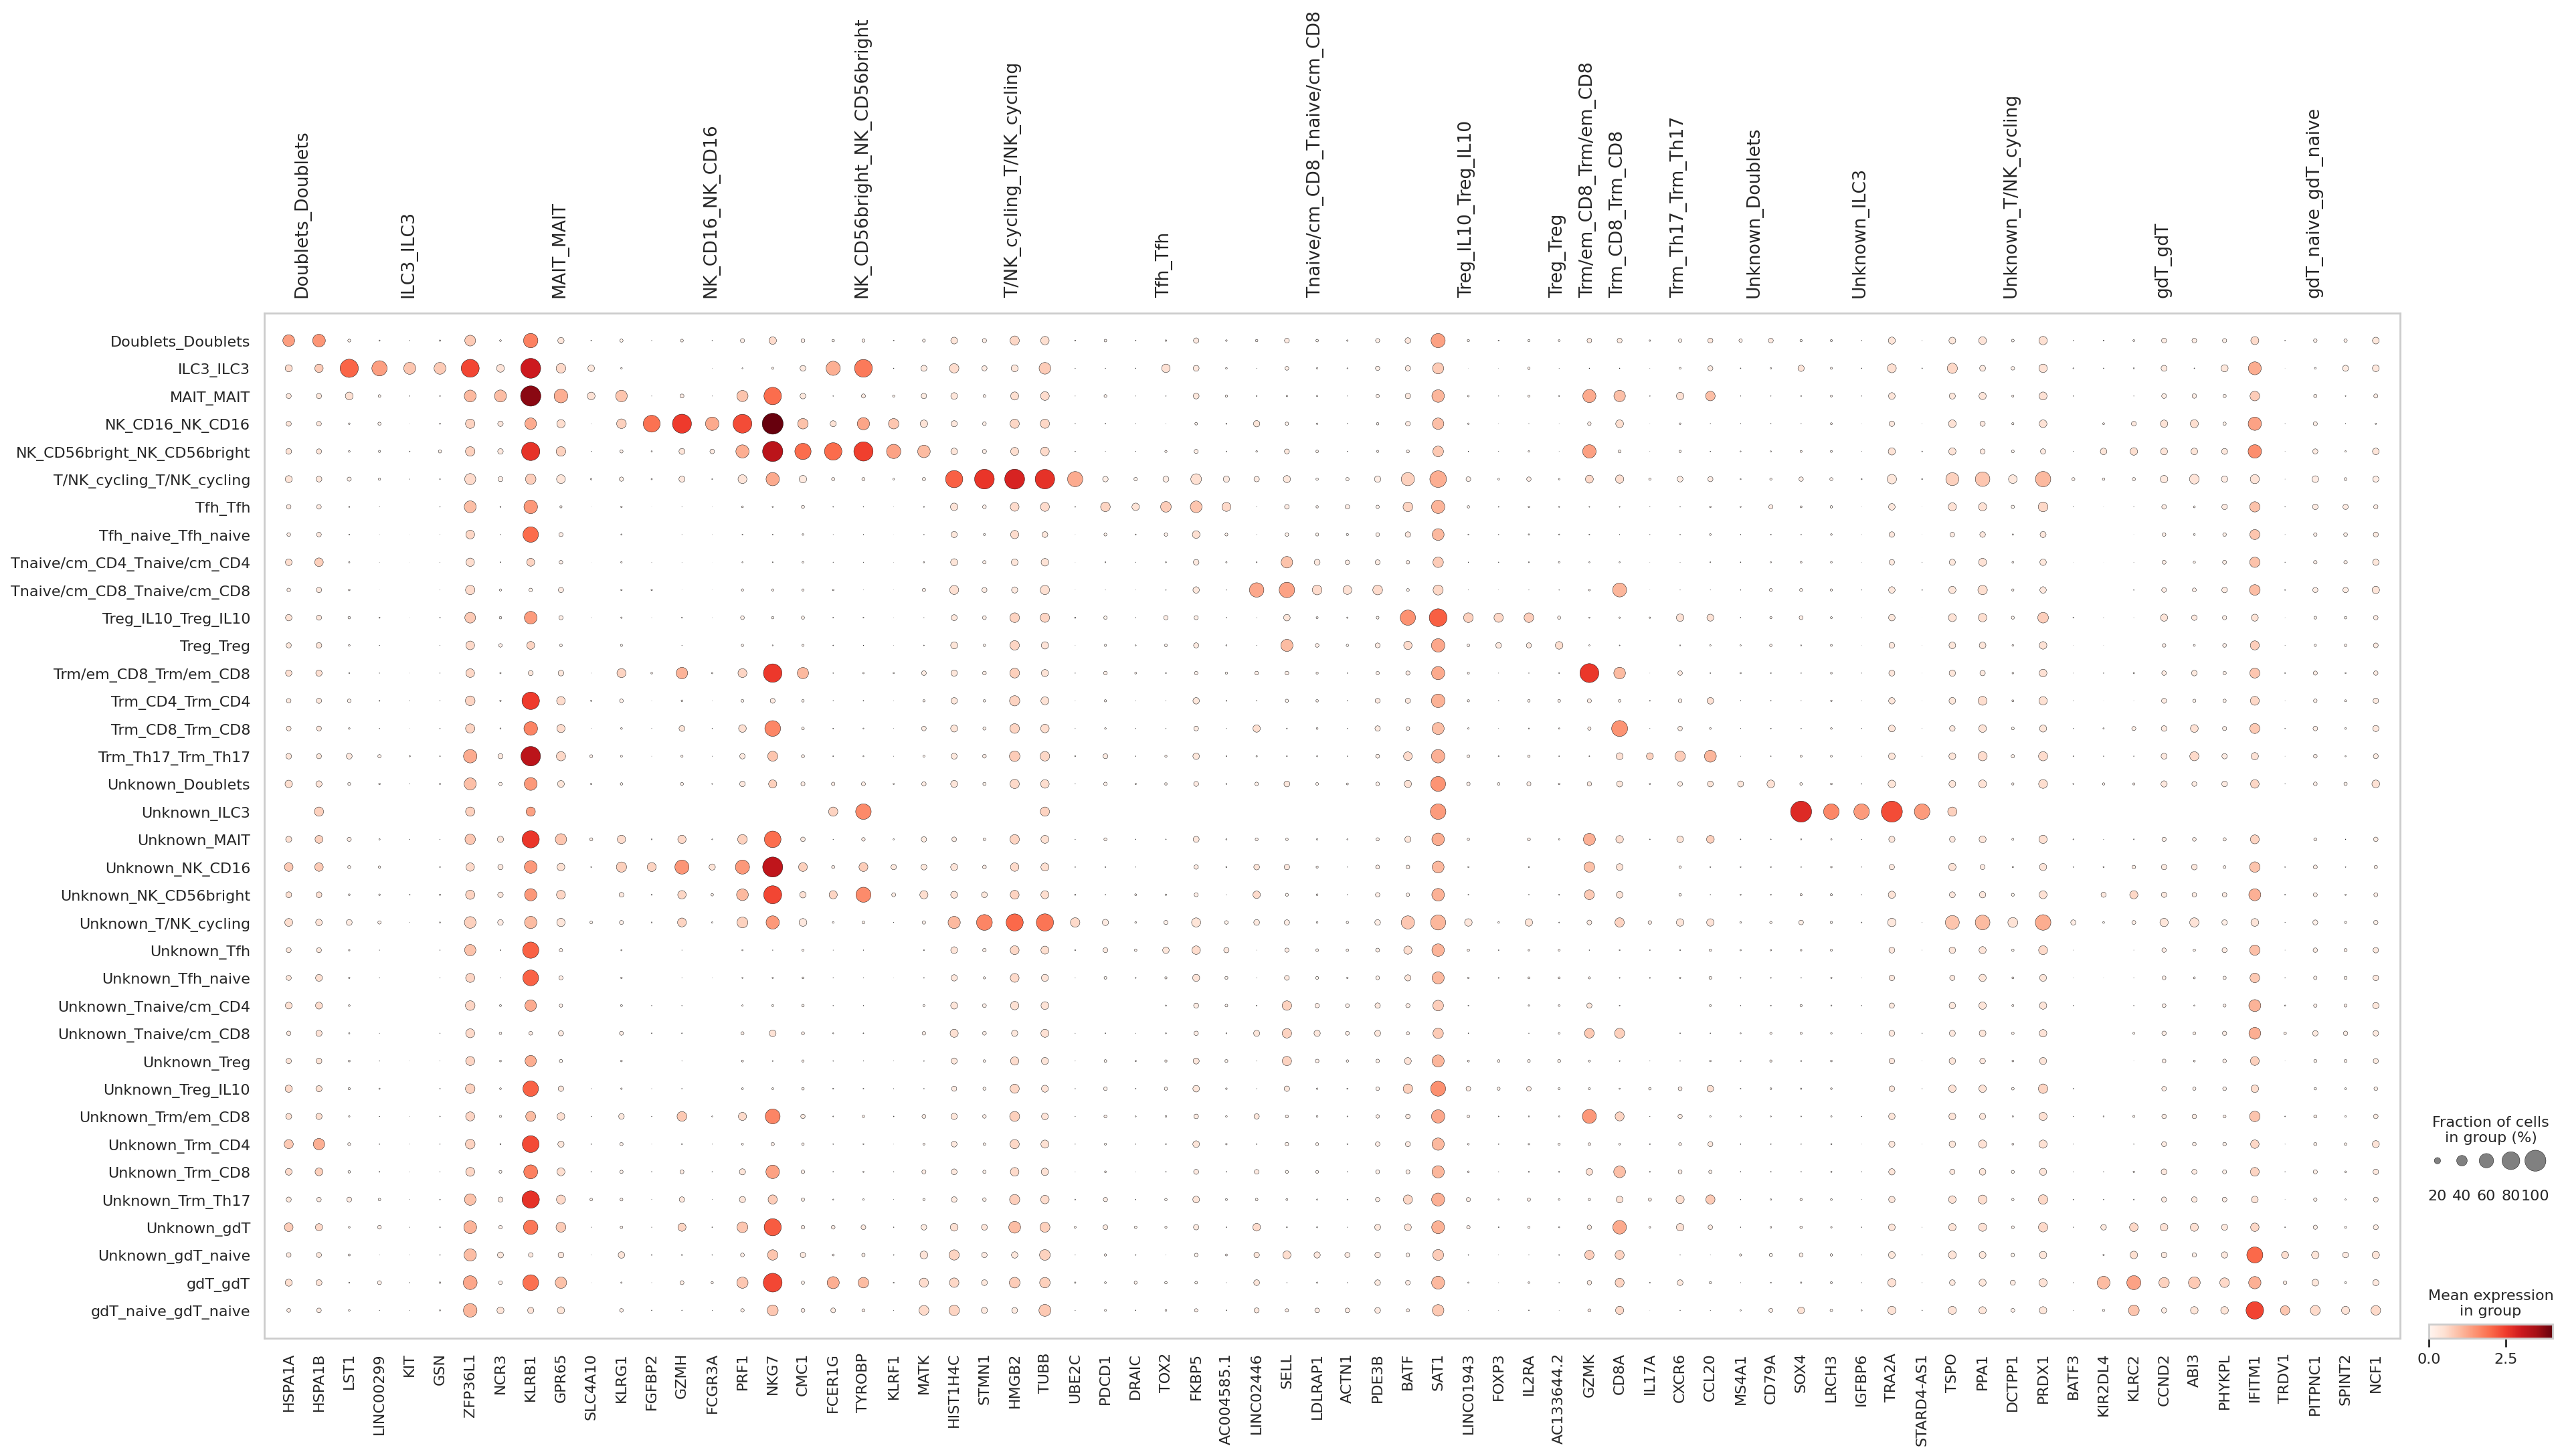

In [48]:
import sys
sys.path.append("/home/jovyan/ao15/Megagut/")
from re5_combine import *
adata.raw = adata.copy()
mkst = calc_marker_stats(adata, groupby="unknown_clusterlabel")
mks = filter_marker_stats(mkst[2], min_frac_diff=0.1, min_mean_diff=0.1, max_next_frac=0.5, max_next_mean=0.95, strict=False, how='or')
plot_markers(adata, groupby='unknown_clusterlabel', mks=mks)

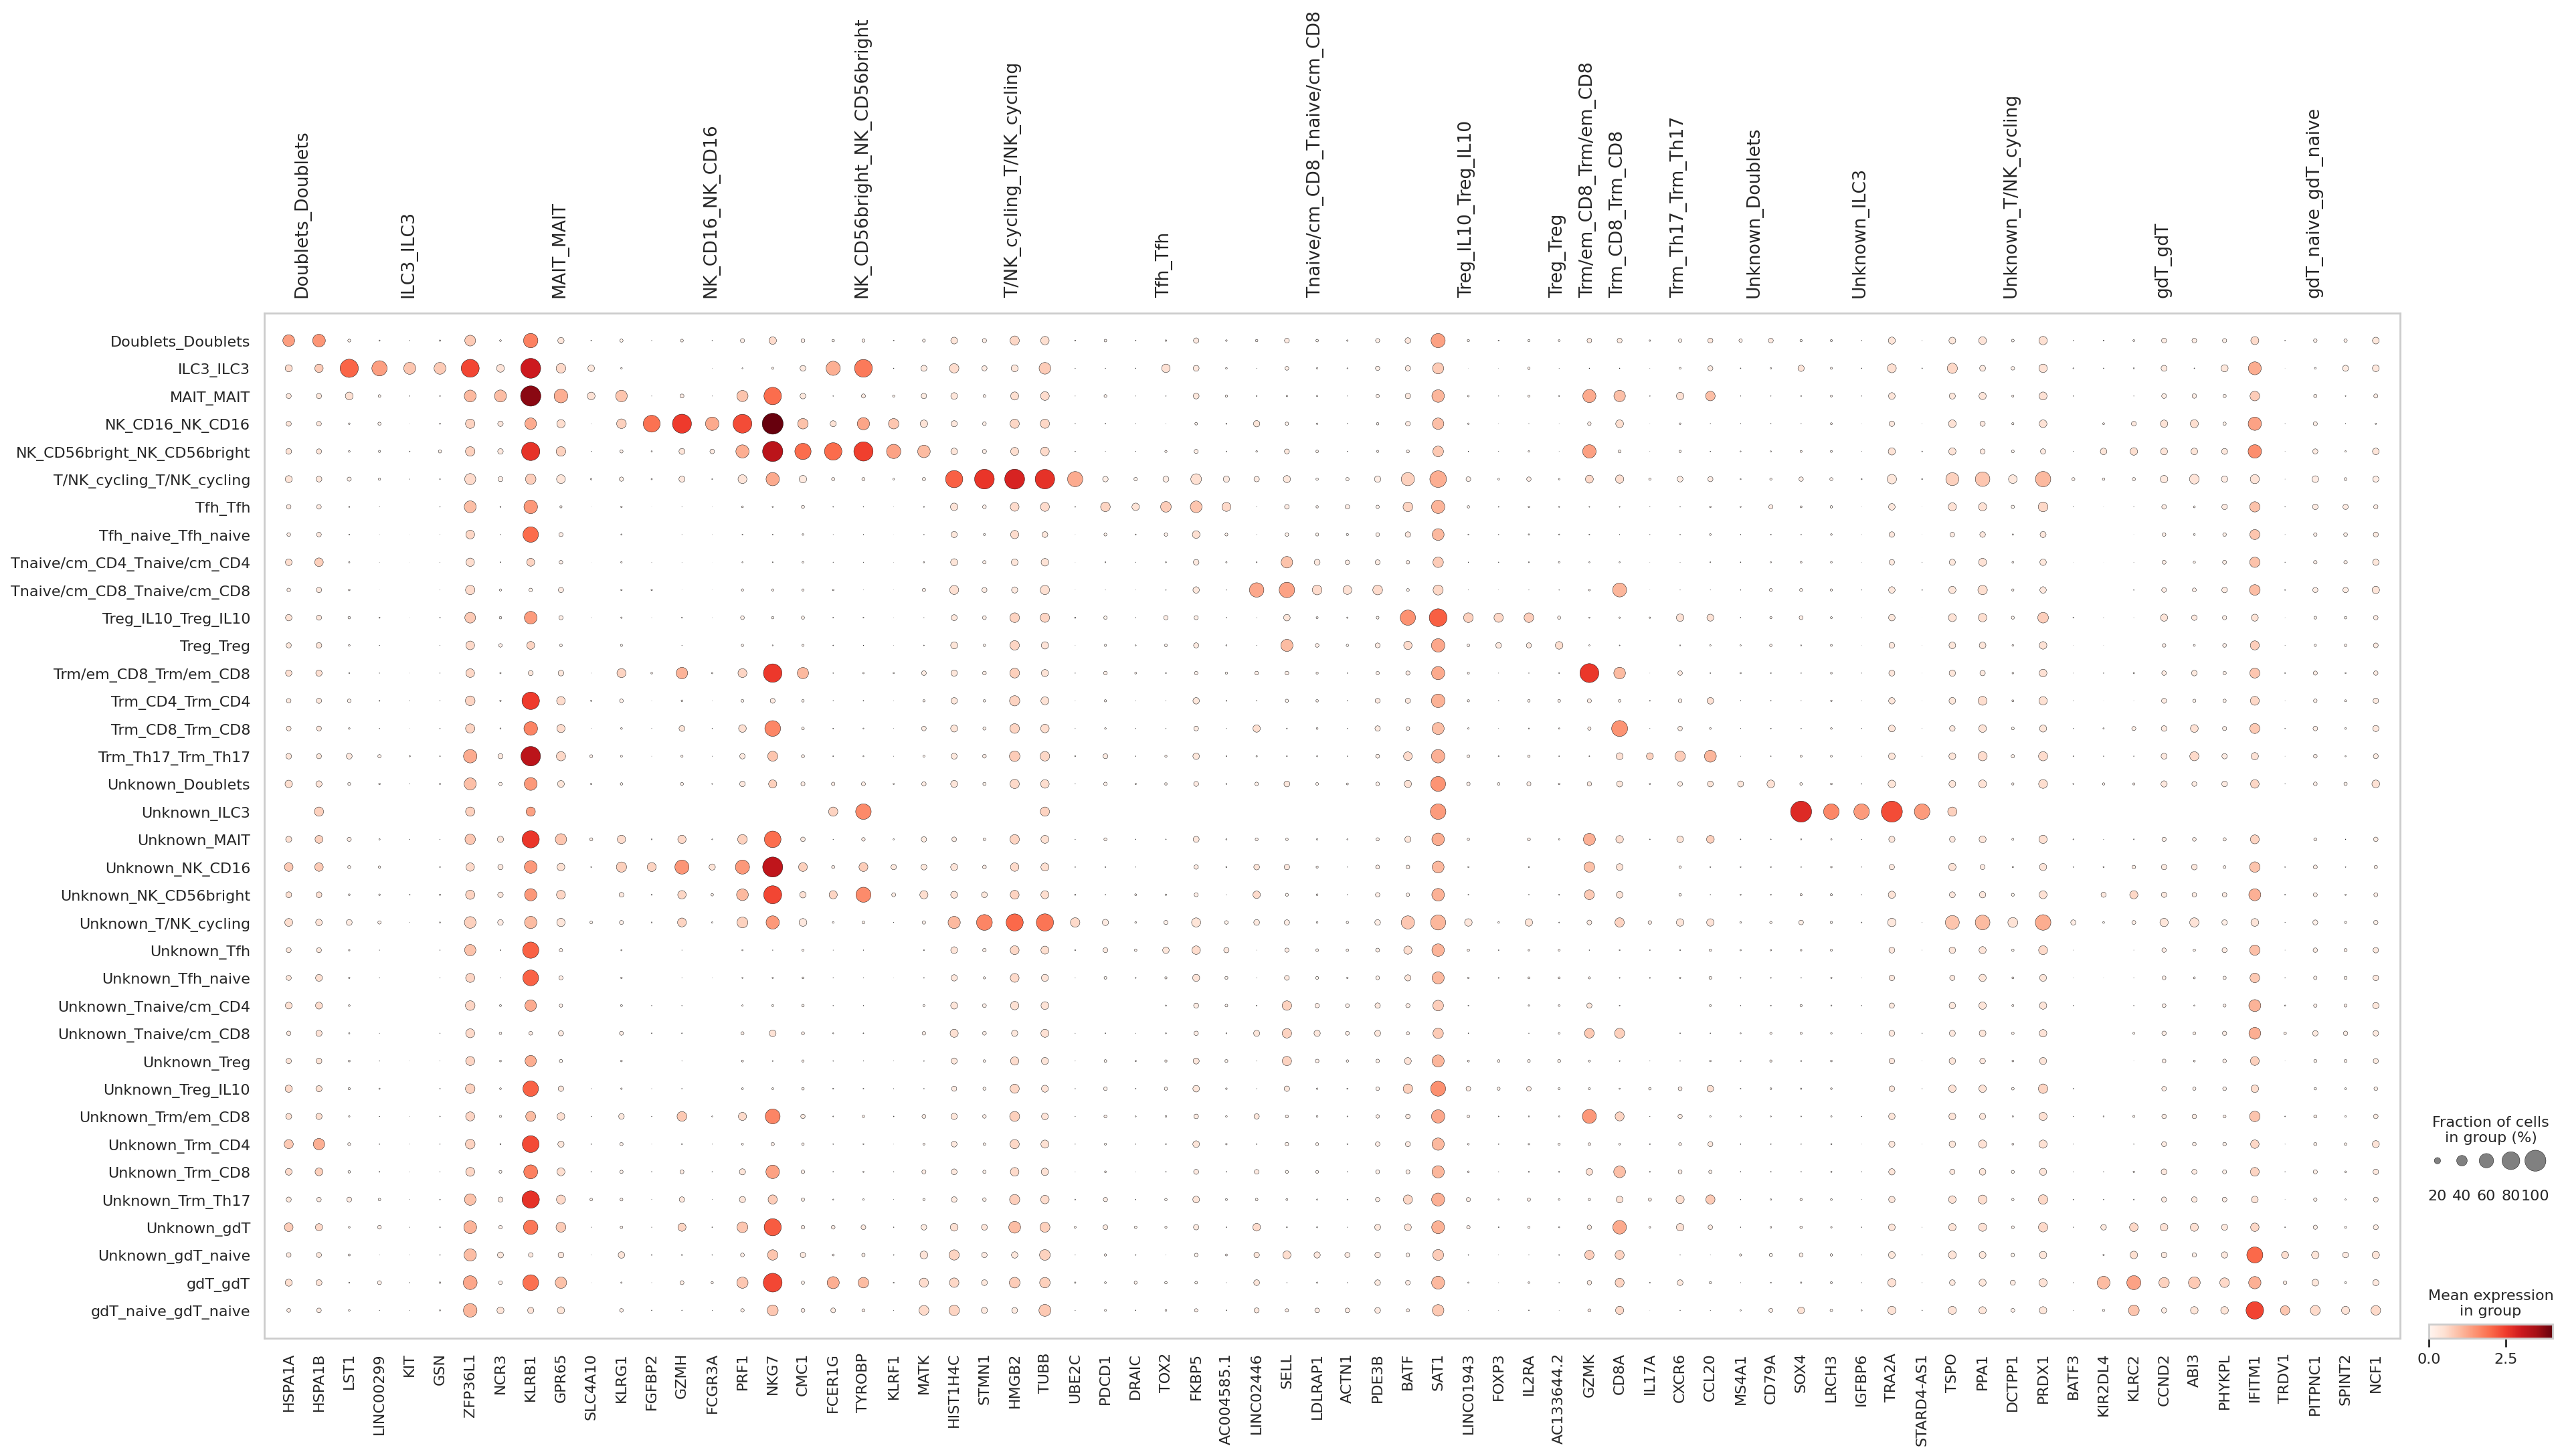

In [49]:
plot_markers(adata, groupby='unknown_clusterlabel', mks=mks,save='TNK_unknown_specificDGE.pdf')